In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd ./drive/MyDrive/Colab\ Notebooks/text_to_image_synthesis
!pwd

/content/drive/MyDrive/Colab Notebooks/text_to_image_synthesis
/content/drive/MyDrive/Colab Notebooks/text_to_image_synthesis


##Learning Deep Representations of Fine-Grained Visual Descriptions

A key challenge in image understanding is to correctly relate natural language concepts to the visual content of images. In other words we aim to learn a text feature representation that captures the most important visual details. 

Based on the method presented by [Scott Reed et al](https://arxiv.org/pdf/1605.05395.pdf) we use the Char CNN-RNN architecture to build a network that trains on `(image, captions)` combinations and outputs an embedding vector that captures their underlying relationship.

### Character level CNN-RNN

This method stacks a recurrent network (RNN) on top of a mid-level temporal CNN hidden layer.  Intuitively, **the CNN output is split along the time dimension** (in this case the RNN steps are `rnn_steps=8`) and treated as an input sequence of vectors.   



The CNN part of the network takes the text sentence as input and is constructed using the following activation function layers: 

* convolution:  `nn.Conv1d`
* thresholding: `nn.Threshold(1e-6, 0)`
* pooling: `nn.MaxPool1d`    

The RNN part of the network takes the above CNNs output and uses `relu` activation functions without biases. 

The high level model architecture is presented in the following image:

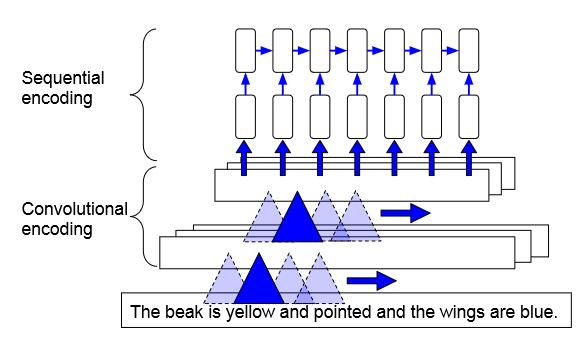

**Objective Function**

The goal of multimodal structured learning methods is to learn a compatibility function of images and text descriptions.

Given $S=\{(v_n, t_n, y_n), n=1,..,N\}$

where:
* visual information $v \in V $
* textual information $t \in T$
* class labels $y \in Y$

The objective is to learn functions $ f_v : V \to Y $ and $ f_t : T \to Y $ that minimize the following risk:

$$ 1/N \sum \limits _{i=1} ^{N} \Delta(y_n, f_v(v_n)+ \Delta(y_n, f_t(t_n)) $$

where $\Delta: Y \times Y \to R$ is the 0-1 loss. $ N $ is the number of image - text pairs.

We observe that the objective function is symmetric to both images and text and as a result a single model can learn to **predict by conditioning on both images and text**.

**Inference Function**

A compatibility function is defined $F : V \times T \in R$ that uses the inner product of the features from image $\theta(v)$ and text $\phi(t)$ encoders.

$$ F(v,t) = \theta(v)^T\phi(t)$$ 

From the perspective of the text encoder, this means that text features must produce a higher compatibility score to a matching image compared to  both:
* the  score  of  that  image  with  any  mismatching text
* the score of that text with any mismatching image.

For the image encoder, we use fine grained 1024 dimensional feature vectors extracted from GoogLeNet. 

The resulting **scoring function** can be  viewed  as  a  linear  accumulation  of  evidence  for  compatibility with a query image: 

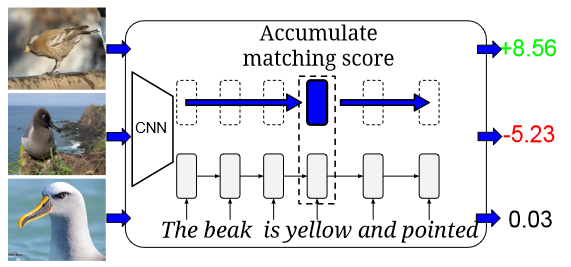

### Text Preprocessing
As described in the original [paper](https://arxiv.org/pdf/1605.05395.pdf), for character-level models (Char-LSTM, Char-CNN, Char-CNN-RNN), the **alphabet** should consist of **all lowercase characters and punctuation**.

The preprocessing steps to transform an english sentence to one-hot tensor are the following:

In [3]:
from utils.text_utils import str_to_labelvec, labelvec_to_onehot

txt = 'A red flower with yellow petals'

# The alphabet used
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "

labels = str_to_labelvec(txt, 200)
labels

tensor([ 1, 70, 18,  5,  4, 70,  6, 12, 15, 23,  5, 18, 70, 23,  9, 20,  8, 70,
        25,  5, 12, 12, 15, 23, 70, 16,  5, 20,  1, 12, 19,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])

In [4]:
onehot = labelvec_to_onehot(labels)
onehot.size()

torch.Size([70, 200])

### Load Pretrained Model

First download the original weights as presented in [Reed, ICML2016](https://github.com/reedscot/icml2016).

The weights are saved as a Torch file so we use the code provided [here](https://github.com/martinduartemore/char_cnn_rnn_pytorch) to parse the weights into the pyTorch model.

In [6]:
pip install torchfile

In [5]:
import torch
from utils.basic_utils import extract_char_cnn_rnn_weights
from models.char_cnn_rnn import char_cnn_rnn

# extract weights from original models
net_state_dict = extract_char_cnn_rnn_weights('./models/lm_sje_flowers_c10_hybrid_0.00070_1_10_trainvalids.txt_iter16400.t7', 'flowers', 'cvpr')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create Char-CNN-RNN model and load weights
net_txt = char_cnn_rnn()
net_txt.load_state_dict(net_state_dict)
net_txt = net_txt.to(device)

print(net_txt)

char_cnn_rnn(
  (conv1): Conv1d(70, 384, kernel_size=(4,), stride=(1,))
  (threshold1): Threshold(threshold=1e-06, value=0)
  (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(384, 512, kernel_size=(4,), stride=(1,))
  (threshold2): Threshold(threshold=1e-06, value=0)
  (maxpool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(512, 512, kernel_size=(4,), stride=(1,))
  (threshold3): Threshold(threshold=1e-06, value=0)
  (maxpool3): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): fixed_rnn(
    (i2h): Linear(in_features=512, out_features=512, bias=True)
    (h2h): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_proj): Linear(in_features=512, out_features=1024, bias=True)
)


**Model Parameters**

The model has a total of 2.994.560 trainable parameters.

In [7]:
for p in net_txt.parameters():
  print(f'For tensor : {p.size()} the number of parameters: {p.numel()}')

total_params = sum(p.numel() for p in net_txt.parameters() if p.requires_grad)

print('-'*40)
print(f'Total Trainable Parameters : {total_params}')
print('-'*40)

For tensor : torch.Size([384, 70, 4]) the number of parameters: 107520
For tensor : torch.Size([384]) the number of parameters: 384
For tensor : torch.Size([512, 384, 4]) the number of parameters: 786432
For tensor : torch.Size([512]) the number of parameters: 512
For tensor : torch.Size([512, 512, 4]) the number of parameters: 1048576
For tensor : torch.Size([512]) the number of parameters: 512
For tensor : torch.Size([512, 512]) the number of parameters: 262144
For tensor : torch.Size([512]) the number of parameters: 512
For tensor : torch.Size([512, 512]) the number of parameters: 262144
For tensor : torch.Size([512]) the number of parameters: 512
For tensor : torch.Size([1024, 512]) the number of parameters: 524288
For tensor : torch.Size([1024]) the number of parameters: 1024
----------------------------------------
Total Trainable Parameters : 2994560
----------------------------------------


### Dataset 


Download the preprocessed flowers dataset from the original authors [github](https://github.com/reedscot/cvpr2016). This dataset contains precomputed the image feature vectors from a GoogleNet. 

The Flowers dataset contains **8189 flower images**  from  **102  different  categories**. The images are split into 82 training + validation and 20 test classes.

The original  [Oxford Flowers-102 (Flowers)](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/) dataset. 

In [ ]:
!mkdir '/content/sample_data/flowers'

In [ ]:
!tar -xf './data/cvpr2016_flowers.tar.gz' -C '/content/sample_data/flowers/'

### Train

During training,  in each mini-batch we first sample **an image from each class**, and then sample **one of its ten corresponding captions**.

In [8]:
import os
import sys
import random
import torch
from datetime import datetime
from torch.utils.data import DataLoader
from utils.basic_utils import init_weights
from models.char_cnn_rnn import char_cnn_rnn

seed = 10
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

**Deep Structured Joint Embedding**

As implemented [here](https://github.com/martinduartemore/char_cnn_rnn_pytorch)

In [9]:
def sje_loss(feat1, feat2):
    ''' 
    Structured Joint Embedding Loss 
    
    as implemented in: 
    '''
    # similarity score matrix (rows: fixed feat2, columns: fixed feat1)
    scores = torch.matmul(feat2, feat1.t()) # (B, B)
    # diagonal: matching pairs
    diagonal = scores.diag().view(scores.size(0), 1) # (B, 1)
    # repeat diagonal scores on rows
    diagonal = diagonal.expand_as(scores) # (B, B)
    # calculate costs
    cost = (1 + scores - diagonal).clamp(min=0) # (B, B)
    # clear diagonals (matching pairs are not used in loss computation)
    cost[torch.eye(cost.size(0), dtype=torch.bool)] = 0 # (B, B)
    # sum and average costs
    denom = cost.size(0) * cost.size(1)
    loss = cost.sum() / denom

    # batch accuracy
    max_ids = torch.argmax(scores, dim=1)
    ground_truths = torch.LongTensor(range(scores.size(0))).to(feat1.device)
    num_correct = (max_ids == ground_truths).sum().float()
    accuracy = 100 * num_correct / cost.size(0)

    return loss, accuracy

In [10]:
epochs=300
batch_size=40
learning_rate=0.0004
learning_rate_decay = 0.98 
print_every=100
checkpoint_dir='./models/'
save_file='cnn_rnn'

device = 'cuda' if torch.cuda.is_available() and args.use_gpu else 'cpu'

In [11]:
from torch.utils.data import DataLoader
from utils.text_embed_dataloader import MultimodalDataset

# The possible splits : ['train', 'val', 'test', 'trainval', 'all']

split = 'trainval'
dataset = MultimodalDataset('/content/sample_data/flowers', split)

loader = DataLoader(dataset, 
                    batch_size=batch_size, 
                    shuffle=True, 
                    num_workers=1, 
                    pin_memory=True)
loader_len = len(loader)

In [12]:
train_loss1 = []  
train_loss2 = [] 
train_acc1 = [] 
train_acc2 = [] 
train_acc1_smooth = [] 
train_acc2_smooth = [] 
train_lr = [] 

os.makedirs(os.path.join(checkpoint_dir, save_file), exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H_%M')
model_name = '{}_{:.5f}_{}_{}.pth'.format( save_file,
        learning_rate , split, timestamp)

ckpt_path = os.path.join(checkpoint_dir, save_file, model_name)


net_txt = char_cnn_rnn().to(device)
net_txt.apply(init_weights)

optim_txt = torch.optim.RMSprop(net_txt.parameters(), lr=learning_rate)

# Decays the learning rate of each parameter group by gamma every epoch.
sched_txt = torch.optim.lr_scheduler.ExponentialLR(optim_txt,learning_rate_decay)

acc1_smooth = 0
acc2_smooth = 0

In [ ]:
for epoch in range(epochs) :
    for i, data in enumerate(loader):
        iter_num = (epoch * loader_len) + i + 1

        net_txt.train()
        img = data['img'].to(device)
        txt = data['txt'].to(device)

        feat_txt = net_txt(txt)
        feat_img = img

        loss1, acc1 = sje_loss(feat_txt, feat_img)
        loss2, acc2 = sje_loss(feat_img, feat_txt)

        loss = loss1 + loss2

        acc1_smooth = 0.99 * acc1_smooth + 0.01 * acc1
        acc2_smooth = 0.99 * acc2_smooth + 0.01 * acc2

        net_txt.zero_grad()
        loss.backward()
        optim_txt.step()
 
        if (iter_num % loader_len) == 0:
            run_info = (
                    'epoch: [{:3d}/{:3d}] | step: [{:4d}/{:4d}] | '
                    'loss: {:.4f} | loss1: {:.4f} | loss2: {:.4f} | '
                    'acc1: {:.2f} | acc2: {:.2f} | '
                    'acc1_smooth: {:.3f} | acc2_smooth: {:.3f} | '
                    'lr: {:.8f}'
            ).format(epoch+1,  epochs, (i+1), loader_len,
                    loss, loss1, loss2,
                    acc1, acc2,
                    acc1_smooth, acc2_smooth,
                    sched_txt.get_last_lr()[0])
            print(run_info)

            # Update metrics
            train_loss1.append(loss1)         
            train_loss2.append(loss2)         
            train_acc1.append(acc1)          
            train_acc2.append(acc2)         
            train_acc1_smooth.append(acc1_smooth)   
            train_acc2_smooth.append(acc2_smooth)   
            train_lr.append(sched_txt.get_last_lr()[0])            

    net_txt.eval()

    # Save a checkpoint of the model
    torch.save(net_txt.state_dict(), ckpt_path)
    sched_txt.step()

In [ ]:
import pickle

s_path = './models/cnn_rnn/'
with open(s_path+'train_loss1.pkl', 'wb') as f:
  pickle.dump(train_loss1, f)
with open(s_path+'train_loss2.pkl', 'wb') as f:
  pickle.dump(train_loss2, f)
with open(s_path+'train_acc1.pkl', 'wb') as f:
  pickle.dump(train_acc1, f)
with open(s_path+'train_acc2.pkl', 'wb') as f:
  pickle.dump(train_acc2, f)
with open(s_path+'train_acc1_smooth.pkl', 'wb') as f:
  pickle.dump(train_acc1_smooth, f)
with open(s_path+'train_acc2_smooth.pkl', 'wb') as f:
  pickle.dump(train_acc2_smooth, f)
with open(s_path+'train_lr.pkl', 'wb') as f:
  pickle.dump(train_lr, f)

In [18]:
import pickle
s_path = './models/cnn_rnn/'

# with open(s_path+'train_loss1.pkl', 'rb') as f:
#   train_loss1=pickle.load(f)
with open(s_path+'train_loss2.pkl', 'rb') as f:
  train_loss2=pickle.load(f)
with open(s_path+'train_acc1.pkl', 'rb') as f:
  train_acc1=pickle.load(f)
with open(s_path+'train_acc2.pkl', 'rb') as f:
  train_acc2=pickle.load(f)
with open(s_path+'train_acc1_smooth.pkl', 'rb') as f:
  train_acc1_smooth=pickle.load(f)
with open(s_path+'train_acc2_smooth.pkl', 'rb') as f:
  train_acc2_smooth=pickle.load(f)
with open(s_path+'train_lr.pkl', 'rb') as f:
  train_lr=pickle.load(f)

Text(0.5, 1.0, 'Image Classifier Loss')

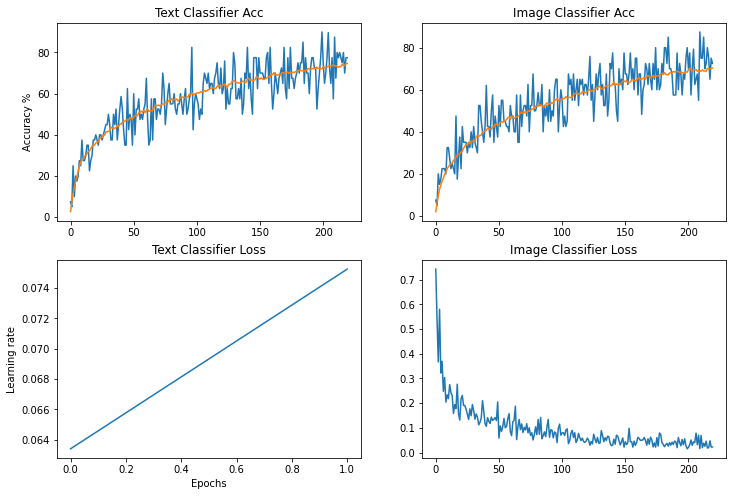

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2,figsize=(12,8))
 
axs[0, 0].plot(train_acc1)
axs[0, 0].plot(train_acc1_smooth)
axs[0, 0].set( ylabel='Accuracy %')
axs[0, 0].set_title('Text Classifier Acc')
axs[0, 1].plot(train_acc2)
axs[0, 1].plot(train_acc2_smooth)
axs[0, 1].set_title('Image Classifier Acc')
axs[1, 0].plot(train_loss1)
axs[1, 0].set_title('Text Classifier Loss')
axs[1, 0].set(xlabel='Epochs', ylabel='Learning rate')
axs[1, 1].plot(train_loss2)
axs[1, 1].set_title('Image Classifier Loss')

### Evaluation

In [13]:
from utils.text_embed_eval import *

net_txt.load_state_dict(torch.load('./models/cnn_rnn/cnn_rnn_0.00040_True_train_2021_07_01_09_51_47.pth'))

net_txt = net_txt.to(device)
net_txt.eval()

data_dir = '/content/sample_data/flowers'
eval_split = 'test'
num_txts_eval = 0

cls_feats_img, cls_feats_txt, cls_list = encode_data(net_txt, None, data_dir,
        eval_split, num_txts_eval, batch_size, device)

mean_ap, cls_stats = eval_retrieval(cls_feats_img, cls_feats_txt, cls_list)
print('----- RETRIEVAL -----')
print('  mAP:')
for k, v in mean_ap.items():
    print('{:.4f}: mAP@{}'.format(v, k))
print('---------------------')
print()

avg_acc, cls_stats = eval_classify(cls_feats_img, cls_feats_txt, cls_list)
print('--- CLASSIFICATION --')
print('Average top-1 accuracy: {:.4f}'.format(avg_acc))
print('---------------------')

----- RETRIEVAL -----
  mAP:
1.0000: mAP@1
0.9800: mAP@5
0.9700: mAP@10
0.8360: mAP@50
---------------------

--- CLASSIFICATION --
Average top-1 accuracy: 0.8545
---------------------
